In [1]:
  # !unzip /content/drive/MyDrive/Kaggle2/Kaggle/real_fake_faces.zip

# Import libraries

In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf 
import tensorflow_hub as hub
%load_ext tensorboard
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator


tf.random.set_seed(42)

#Helper Functions

In [3]:
# Define EarlyStopping callback for model training
def callbacks_early_stopping(monitor='loss', patience=2):
  return tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)

# Define Tensorflow callback for model training
def callbacks_tensorboard(folder_name, experiment_name):
  return tf.keras.callbacks.TensorBoard(log_dir=folder_name + '/' + experiment_name)

def plot_loss_metric(history):
  pd.DataFrame(history.history).plot()
  plt.title('Accuracy Vs Loss')

def show_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix')

def show_random_images(image_dir):
  list_images = random.sample(os.listdir(image_dir), 6)
  list_images = [image_dir + file_name for file_name in list_images]
  i = 0
  rows = 2
  cols = 2
  axes=[]
  fig=plt.figure()

  for a in range(rows*cols):
      axes.append( fig.add_subplot(rows, cols, a+1) )
      axes[-1].set_title(list_images[i].split('/')[4])  
      plt.imshow(plt.imread(list_images[i]))
      axes[-1].axis('off')
      i = i + 1 
  fig.tight_layout()
  plt.show()

# Variables

In [4]:
IMG_SIZE = (224, 224)
CLASSES = ['fake' , 'real']
FAKE_DIR = '/content/real_and_fake_face/training_fake/'
REAL_DIR = '/content/real_and_fake_face/training_real/'
train_dataset_path = '/content/real_and_fake_face'
test_dataset_path = '/content/real_and_fake_face_detection/real_and_fake_face'

# Visual random images

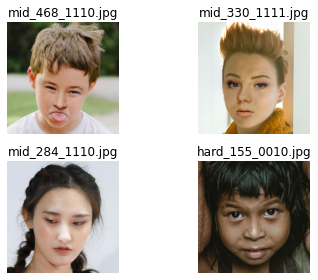

In [5]:
show_random_images(FAKE_DIR)

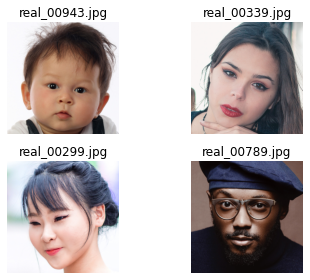

In [6]:
show_random_images(REAL_DIR)

# Loading data

In [7]:
# Non-Augmented Datasettraining dataset
# train_gen = ImageDataGenerator()
# train = train_gen.flow_from_directory(train_dataset_path,
#                                       batch_size=32,
#                                       target_size=(224, 224),
#                                       class_mode='categorical',
#                                       shuffle=True, 
#                                       seed=42)

# Augmented training dataset
train_gen_augmented = ImageDataGenerator( horizontal_flip=True,
                                          rotation_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2)
train_augmented = train_gen_augmented.flow_from_directory(train_dataset_path,
                                      batch_size=32,
                                      target_size=(224, 224),
                                      class_mode='categorical',
                                      shuffle=True,
                                      seed=42)

# Testing dataset
test_gen = ImageDataGenerator()
test = test_gen.flow_from_directory(test_dataset_path,
                                    batch_size=32,
                                    target_size=(224, 224),
                                    class_mode='categorical',
                                    shuffle=False,
                                    seed=42)

Found 2041 images belonging to 2 classes.
Found 2041 images belonging to 2 classes.


# Training base model using EfficientNetB7

In [8]:
checkpoint_path = '/content/checkpoint/checkpoint.ckpt'

In [9]:
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,))
x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalMaxPooling2D()(x)
outputs = tf.keras.layers.Dense(units=2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', metrics=['accuracy'], loss=tf.keras.losses.CategoricalCrossentropy())

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='accuracy',
    save_freq='epoch',
    verbose=1,
    save_best_only=False)

history = model.fit(train_augmented, epochs=30, callbacks=[model_checkpoint_callback, callbacks_tensorboard('logs', 'base_model'), callbacks_early_stopping()])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 1.0982 - accuracy: 0.5051
Epoch 00001: saving model to /content/checkpoint/checkpoint.ckpt
64/64 [==============================] - 62s 690ms/step - loss: 1.0982 - accuracy: 0.5051
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 1.1248 - accuracy: 0.5277
Epoch 00002: saving model to /content/checkpoint/checkpoint.ckpt
64/64 [==============================] - 44s 686ms/step - loss: 1.1248 - accuracy: 0.5277
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.5772
Epoch 00003: saving model to /content/checkpoint/checkpoint.ckpt
64/64 [==============================] - 45s 694ms/step - loss: 0.8486 - accuracy: 0.5772
Epoch 4/30
64/64 [==============================] - ETA: 0s - loss: 0.8081 - accuracy: 0.5816
Epoch 00004: saving model to /content/checkpoint/checkpoint.ckpt
64/64 [==============================] - 44s 685ms/step - loss: 0.8081 - accuracy: 0.5816
Epoc

In [10]:
model.evaluate(test)

64/64 [==============================] - 29s 388ms/step - loss: 1.0359 - accuracy: 0.5365


[1.0359256267547607, 0.5365017056465149]

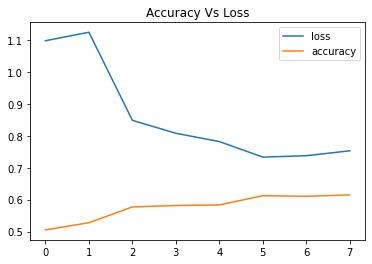

In [11]:
plot_loss_metric(history)

# Loading saved checkpoint (weights) from previously trained model

In [12]:
# Loading weights from saved checkpoint
model.load_weights(checkpoint_path)

# Fine-tuning base model

In [13]:
# Set last 10 layers of the base model to trainable
base_model.trainable = True

for  layer in base_model.layers[:-10]:
  layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'], loss=tf.keras.losses.CategoricalCrossentropy())
history = model.fit(train_augmented, epochs=50, callbacks=[callbacks_tensorboard('logs', 'ft_model'), callbacks_early_stopping()])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
64/64 [==============================] - 59s 667ms/step - loss: 0.7777 - accuracy: 0.6075
Epoch 2/50
64/64 [==============================] - 43s 673ms/step - loss: 0.6682 - accuracy: 0.6497
Epoch 3/50
64/64 [==============================] - 43s 670ms/step - loss: 0.5982 - accuracy: 0.6908
Epoch 4/50
64/64 [==============================] - 43s 672ms/step - loss: 0.5823 - accuracy: 0.7144
Epoch 5/50
64/64 [==============================] - 43s 671ms/step - loss: 0.5335 - accuracy: 0.7291
Epoch 6/50
64/64 [==============================] - 43s 673ms/step - loss: 0.5084 - accuracy: 0.7550
Epoch 7/50
64/64 [==============================] - 43s 676ms/step - loss: 0.4990 - accuracy: 0.7575
Epoch 8/50
64/64 [==============================] - 43s 674ms/step - loss: 0.4716 - accuracy: 0.7648
Epoch 9/50
64/64 [==============================] - 43s 672ms/step - loss: 0.4418 - accuracy: 0.7957
Epoch 10/50
64/64 [==============================] - 43s 672ms/step - loss: 0.4161 - accura

In [14]:
model.evaluate(test)

64/64 [==============================] - 29s 389ms/step - loss: 0.1457 - accuracy: 0.9525


[0.1456710249185562, 0.9524742960929871]

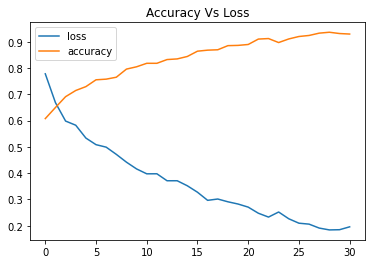

In [15]:
plot_loss_metric(history)

In [16]:
y_probs = model.predict(test)

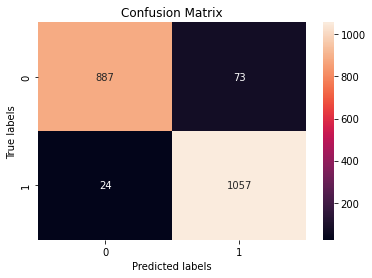

In [17]:
y_true = test.labels
y_pred = list(tf.argmax(y_probs, axis=1).numpy())
show_confusion_matrix(y_true=y_true, y_pred=y_pred)

# Prediction

In [18]:
def predict_image(model, path, target_size=(224, 224)):
  keras_image = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
  image = tf.keras.preprocessing.image.img_to_array(keras_image)
  image = tf.expand_dims(image, axis=0)
  classes = model.predict(image)
  return CLASSES[tf.argmax(classes, axis=1).numpy()[0]]

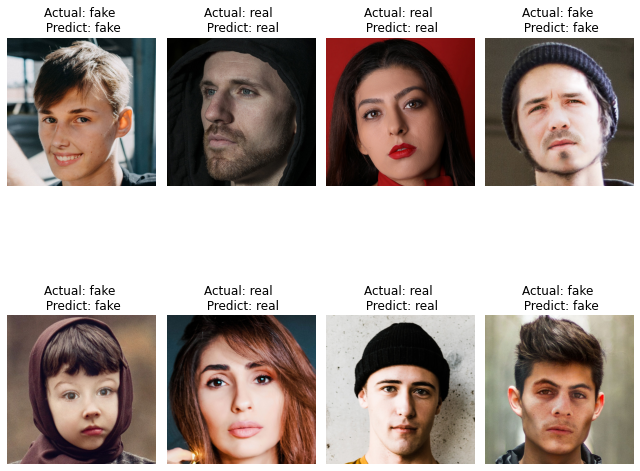

In [19]:
real_image_list = random.sample(os.listdir(REAL_DIR), 4)
real_image_list = [REAL_DIR + file_name for file_name in real_image_list]

fake_image_list = random.sample(os.listdir(FAKE_DIR), 4)
fake_image_list = [FAKE_DIR + file_name for file_name in fake_image_list]

image_list = real_image_list + fake_image_list
random.shuffle(image_list)
prediction_list = [predict_image(model, image_path, IMG_SIZE) for image_path in image_list]

def format_actual_title(value):
  return value.split('/')[3].replace('training_', '')

i = 0
rows = 2
cols = 4
axes=[]
fig=plt.figure(figsize=(9, 9))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    axes[-1].set_title(f"Actual: {format_actual_title(image_list[i])} \n Predict: {prediction_list[i]}")  
    plt.imshow(plt.imread(image_list[i]))
    axes[-1].axis('off')
    i = i + 1 
fig.tight_layout()
plt.show()